# Actor Critic

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.pendulum import pendulum

env = pendulum(mass=1, length=1, gravity=9.81)
env.step_size = 0.05

# Define reward function

angle_normalize =  lambda x: ((x+np.pi) % (2*np.pi)) - np.pi
env.reward = lambda : -angle_normalize(env.x[0])**2 - 0.1*env.x[1]**2 -0.01*env.u**2

# Define terminal state
env.terminal = lambda : np.abs(env.x[1]) > 3*np.pi

# Define state variabels
env.state = lambda : np.array([np.cos(env.x[0]), np.sin(env.x[0]), env.x[1]])

In [3]:
import tensorflow.contrib.slim as slim
import tensorflow as tf
import numpy as np
import gym

## Actor class
The following codes sets up the neural network for the actor. The actor has two functions, the choose_action and learn functions.

### The Network
The Actor network consists of some hidden layers which learns the abstraction of the inpuut action. This then feeds into two layers which learn the standard deviation $\sigma$, and the mean $\mu$ of the normaldistribution (see the image below), which decides which action to take. 
<img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg" alt="Drawing" style="width: 300px;"/>

### Choosing an action
The action to take is chosen by feeding a state into the network, and predicting the resulting standard deviation $\sigma$ and mean $\mu$. A random action based on the distribution is then chosen.

### Learning
The learning alorithem works by finding the probability of the action taken given the distribution. $P(a)$, it then computes the log probability and multiplies this with the temporal diference error, which guides the gradient decent in the direction which will give a better value then the current policy, and away from areas which give a worse value then with the current policy.

In [4]:
class Actor(object):
    def __init__(self, sess, n_features, n_actions, action_bound, hidden_layer_shape = [32], lr=1e-4, min_variance = 0.1):
        self.sess = sess
        self.action_offset = (action_bound[1] + action_bound[0])/2
        self.action_scale = (action_bound[1] - action_bound[0])/2
        self.min_variance = min_variance
        
        # Placeholders for action and td_error for learning, and state for learning and action selection
        self.state = tf.placeholder(tf.float32, [None, n_features], "state")
        self.action_holder = tf.placeholder(tf.float32, None, name="action")
        self.td_error = tf.placeholder(tf.float32, None, name="td_error")  # TD_error
        
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        
        # Actor hidden layers
        hidden = slim.stack(
            inputs = self.state,
            layer = slim.fully_connected, 
            stack_args = hidden_layer_shape,
            activation_fn = tf.nn.relu, 
            weights_regularizer = regularizer,
            weights_initializer = tf.random_normal_initializer(0., .1),  # weights
            biases_initializer = tf.constant_initializer(0.1),  # biases
            scope='hidden'
        )
        
        hidden1, hidden2 = tf.split(value = hidden,
                                    num_or_size_splits = 2, 
                                    axis = 1, 
                                    name = "mu_sigma_split"
        )
        
        # Predicted mean
        mu = tf.layers.dense(
            inputs=hidden1,
            units=n_actions,
            activation=tf.nn.tanh,
            kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
            bias_initializer=tf.constant_initializer(0.1),  # biases
            name='mu'
        )
        
        # Predicted standard deviation
        sigma = tf.layers.dense(
            inputs=hidden2,
            units=n_actions,
            activation=tf.nn.softplus,  # get action probabilities
            kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
            bias_initializer=tf.constant_initializer(1.),  # biases
            name='sigma'
        )
        # Decaying learning rate (include global step in optimizer)
            #global_step = tf.Variable(0, trainable=False)
            # self.e = epsilon = tf.train.exponential_decay(2., global_step, 1000, 0.9)
            
        # Scale mu to fill action space, and add minimum varaince to sigma
        self.mu = mu*self.action_scale + self.action_offset
        self.sigma = self.action_scale*(sigma + self.min_variance)
        
        # Create normal distribution based on sigma and mu
        self.normal_dist = tf.distributions.Normal(self.mu, self.sigma)

        # Draw action from normal distribution given sigma and mu
        self.action = tf.clip_by_value(self.normal_dist.sample(1), action_bound[0], action_bound[1])[0]

        with tf.name_scope('loss'):
            log_prob = self.normal_dist.log_prob(self.action_holder)  # loss without advantage
            self.loss = log_prob * self.td_error  # advantage (TD_error) guided loss
            # Add cross entropy cost to encourage exploration
            self.loss += 0.01*self.normal_dist.entropy()

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.loss)

    def learn(self, state, action, td_error, batch = False):
        if batch == False:
            state = state[np.newaxis, :]
        feed_dict = {self.state: state, self.action_holder: action, self.td_error: td_error}
        _, loss = self.sess.run([self.train_op, self.loss], feed_dict)
        return loss

    def choose_action(self, state, batch = False):
        if batch == False:
            state = state[np.newaxis, :]
        return self.sess.run([self.action, self.mu, self.sigma], {self.state: state})  # get probabilities for all actions
    
    

## Critic class
The critic is responsible for estimating the value function of the policy the actor is following. It does so by using a neural network to parameterize the value function $V(s)$. To find the best parameterization of the value function the critic learns by updating the value function using the temporal difference error $r + \gamma V(s') - V(s)$ whith the loss function as the squared temporal difference error.

In [5]:
class Critic(object):
    def __init__(self, sess, n_features, gamma = 0.9, hidden_layer_shape = [32, 64], lr=1e-3):
        self.sess = sess
        self.gamma = gamma
        with tf.name_scope('inputs'):
            self.state = tf.placeholder(tf.float32, [None, n_features], "state")
            self.v_next = tf.placeholder(tf.float32, [None, 1], name="v_next")
            self.reward = tf.placeholder(tf.float32, None, name='reward')
            self.terminal = tf.placeholder(tf.float32, None, name='terminal')

        with tf.variable_scope('Critic'):
            regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
            hidden = slim.stack(inputs = self.state,
                                layer = slim.fully_connected, 
                                stack_args = hidden_layer_shape,
                                activation_fn = tf.nn.relu, 
                                weights_regularizer = regularizer,
                                weights_initializer = tf.random_normal_initializer(0., .1),  # weights
                                biases_initializer = tf.constant_initializer(0.1),  # biases
                                scope='hidden'
            )

            self.v = tf.layers.dense(
                inputs=hidden,
                units=1,
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='value_function'
            )

        with tf.variable_scope('squared_TD_error'):
            self.end_multiplier = 1 - self.terminal
            self.td_error = self.reward + self.gamma*self.v_next*self.end_multiplier - self.v 
            self.loss = tf.square(tf.reduce_mean(self.td_error))
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, state, reward, state_next, terminal = np.array([]), batch = False):
        if batch == False:
            state = state[np.newaxis, :]
            state_next = state_next[np.newaxis, :]
            
        if terminal.size == 0:
            terminal = np.zeros_like(reward)
        
        # Get value of next state
        v_next = self.sess.run(self.v, {self.state: state_next})
        
        # Gradient decent using td_error
        train_dict = {self.state: state, self.v_next: v_next, self.reward: reward, self.terminal: terminal}
        td_error, _ = self.sess.run([self.td_error, self.train_op], train_dict)
        return td_error

## Experience replay buffer
The idea behind the experience replay buffer is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. The experience is stored as a tuple $[s, a, r, s']$ where $s$ is the state we are in, $a$ is the action we take, $r$ is the reward we get, and $s'$ is the state we end up in. 

In [6]:
import random
class experience_buffer():
    def __init__(self, buffer_size = 1000000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [7]:
np.random.seed(2)
tf.set_random_seed(2)

# Reset graph
tf.reset_default_graph()

# Training parameters
MAX_EPISODES = 2000
MAX_EP_STEPS = 200
BATCH_SIZE = 2
GAMMA = 0.9
LR_A = 1e-4    # learning rate for actor
LR_C = 1e-3    # learning rate for critic

# create experience buffer
experience = experience_buffer()

# Save and show reward
running_reward = 0
reward_list = []

nx = len(env.state()) #number of states
nu = 1 #Number of inputs
a_max = 5

sess = tf.Session()

# Set up actor and critic
actor = Actor(sess, n_features=nx, n_actions=nu, lr=LR_A, action_bound=[-a_max, a_max], hidden_layer_shape=[64], min_variance=0.01)
critic = Critic(sess, n_features=nx, gamma=GAMMA, lr=LR_C)
sess.run(tf.global_variables_initializer())

In [8]:
for i_episode in range(MAX_EPISODES):
    theta = (2*np.random.random() - 1)*np.pi
    theta_dot = (2*np.random.random() - 1)*5
    s = env.init([theta,theta_dot])
    t = 1
    ep_rs = []
    while True:
        # Choose action (Actor)
        a, mu, sigma = actor.choose_action(s)
        
        # Perform action and observe reward and next state
        s_ = env.step(a)
        r = env.reward()
        done = env.terminal()
        
        # Save experience
        experience.add(np.reshape(np.array([s,a,np.array(r/10),s_,np.array(done)]),[1,5]))
        
        if t%BATCH_SIZE == 0:
            batch = experience.sample(BATCH_SIZE)
            b_s = np.vstack(batch[:,0])
            b_a = np.vstack(batch[:,1])
            b_r = np.vstack(batch[:,2])
            b_s_ = np.vstack(batch[:,3])
            b_d = np.vstack(batch[:,4])
            
            # gradient = grad[r + gamma * V(s_) - V(s)]
            td_error = critic.learn(b_s, b_r, b_s_, b_d, batch=True)
            
            # Mask out negative experience in order to not train the actor on it
            mask = np.ndarray.flatten(td_error >= 0)
            
            # true_gradient = grad[logPi(s,a) * td_error]
            actor.learn(b_s[mask], b_a[mask], td_error[mask], batch=True)
            
            experience.buffer = []

        s = s_
        t += 1
        ep_rs.append(r)
        if t > MAX_EP_STEPS or done:
            performance = np.sum(ep_rs)
            running_reward = running_reward * 0.9 + performance * 0.1 if running_reward != 0 else performance
            reward_list.append(performance)
            print("\r episode: {0} reward: {1:0.2f}".format( i_episode, running_reward), end = "  ")
            break

 episode: 1999 reward: -284.61  

In [9]:
from ipywidgets import widgets
from matplotlib import pyplot as plt
%matplotlib inline
def plot_moving_average(window_size):
    interval = np.array(reward_list).flatten()
    window= np.ones(int(window_size))/float(window_size)
    data = np.convolve(interval, window, 'valid')
    plt.plot(data)
    plt.show()

slider = widgets.interact(plot_moving_average, window_size=(1, 1000, 1))

In [15]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 400
X = np.zeros((n_steps, len(env.x)))
U = np.zeros((n_steps))
state = env.init([np.pi, 0])
for step in range(n_steps):
    X[step, :] = env.x
    a, mu, sigma = actor.choose_action(state)
    state = env.step(mu)
    U[step] = mu

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
animate = lambda i: line.set_data([0, np.sin(X[i, 0])],[0, np.cos(X[i, 0])])

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

In [16]:
HTML(anim.to_html5_video())

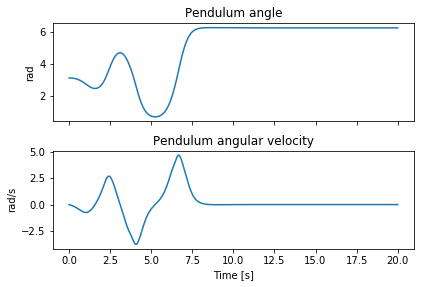

In [17]:
# Plot trajectory
#%matplotlib inline
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Pendulum angle", "Pendulum angular velocity"]
units = ["rad", "rad/s"]
fig, axarr = plt.subplots(2, sharex=True)
for i in range(2):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

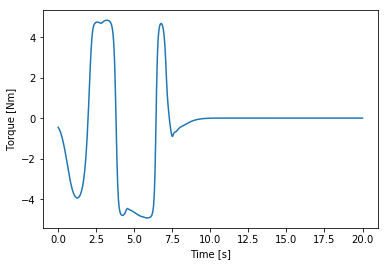

In [18]:
# Plot trajectory
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
plt.figure()
plt.plot(t, U)
plt.ylabel("Torque [Nm]")
plt.xlabel("Time [s]")
plt.show()

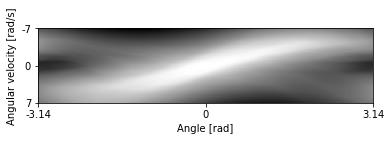

In [19]:
img = np.zeros((140, 628))
value = lambda state: critic.sess.run(critic.v,feed_dict={critic.state:state})
angles = np.linspace(-np.pi, np.pi, 628)
for i, y in enumerate(np.linspace(-7, 7, 140)):
    x = np.column_stack((np.cos(angles), np.sin(angles), y*np.ones((628))))
    img[i, :] = value(x).flatten()

plt.figure()
plt.imshow(img, cmap="gray")
plt.xticks([0, 314, 628],[-3.14, 0, 3.14])
plt.yticks([0, 70, 140], [-7, 0, 7])
plt.xlabel("Angle [rad]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()